**Cylindrical Convection Benchmark**


In [1]:
import underworld as uw
import numpy as np
from underworld import function as fn
uw.matplotlib_inline()
import glucifer

In [2]:
# Model parameters
res_radial    = 40
maxtimesteps  = 3
outputPath    = 'new_cynbench_2.1_test/'

# physical parameters
Ra = 1e4
Di = 0.
t_outer = 0.0
t_inner = 1.0
t_s = 0.091
r_min = 1.22
r_max = 2.22
f = r_min/r_max
ss_tol = 1e-5

# radial position for a discretisation aspect ratio of 1.0 
eq_aspect_r = r_min + 0.75*(r_max-r_min)

res_angular = int(2 * np.pi * eq_aspect_r/(r_max-r_min) * res_radial)
if res_angular % 2:
    res_angular-=1

# Whether or not to start from the previous temperature field
loaddata = False
load_temp_filename='cynbench_2.1_lowres/temperature-0.h5'
load_tDot_filename='cynbench_2.1_lowres/tDot-0.h5'


In [3]:
import matplotlib.pyplot as plt
plt.ion()

In [4]:
# create checkpoint function for later use
def checkpoint( mesh, fieldDict, swarm, swarmDict, index,
                meshName='mesh', swarmName='swarm', 
                prefix='./', enable_xdmf=True, with_deform_mesh=False):
    import os
    # Check the prefix is valid
    if prefix is not None:
        if not prefix.endswith('/'): prefix += '/' # add a backslash
        if not os.path.exists(prefix) and uw.rank()==0:
            print "Creating directory: ",prefix 
            os.makedirs(prefix)
        uw.barrier() 
            
    if not isinstance(index, int):
        raise TypeError("'index' is not of type int")        
    ii = str(index)
    
    # only is there's a mesh then check for fields to save
    if mesh is not None:
        
        # Error check the mesh and fields
        if not isinstance(mesh, uw.mesh.FeMesh):
            raise TypeError("'mesh' is not of type uw.mesh.FeMesh")
        if not isinstance(fieldDict, dict):
            raise TypeError("'fieldDict' is not of type dict")
        for key, value in fieldDict.iteritems():
            if not isinstance( value, uw.mesh.MeshVariable ):
                raise TypeError("'fieldDict' must contain uw.mesh.MeshVariable elements")

        # Save the mesh each call of checkpoint() if with_deform_mesh is enabled
        if with_deform_mesh is True:
            mh = mesh.save(prefix+meshName+".h5")
        else:
            # see if we have already saved the mesh. It only needs to be saved once
            if not hasattr( checkpoint, 'mH' ):
                checkpoint.mH = mesh.save(prefix+meshName+".h5")
            mh = checkpoint.mH

        # save xdmf files
        for key,value in fieldDict.iteritems():
            filename = prefix+key+'-'+ii
            handle = value.save(filename+'.h5', mh)
            if enable_xdmf: value.xdmf(filename, handle, key, mh, meshName)
        
    # is there a swarm
    if swarm is not None:
        
        # Error check the swarms
        if not isinstance(swarm, uw.swarm.Swarm):
            raise TypeError("'swarm' is not of type uw.swarm.Swarm")
        if not isinstance(swarmDict, dict):
            raise TypeError("'swarmDict' is not of type dict")
        for key, value in swarmDict.iteritems():
            if not isinstance( value, uw.swarm.SwarmVariable ):
                raise TypeError("'fieldDict' must contain uw.swarm.SwarmVariable elements")
        
        # save xdmf files
        sH = swarm.save(prefix+swarmName+"-"+ii+".h5")
        for key,value in swarmDict.iteritems():
            filename = prefix+key+'-'+ii
            handle = value.save(filename+'.h5')
            if enable_xdmf: value.xdmf(filename, handle, key, sH, swarmName)


In [5]:
# create mesh and required fields
annulus = uw.mesh._FeMesh_Annulus(elementRes=(res_radial,res_angular), 
                                  radialLengths=(r_min,r_max), angularExtent=(0.,360.),
                                  periodic = [False, True])


tField = uw.mesh.MeshVariable(annulus, nodeDofCount=1)
tDotField = uw.mesh.MeshVariable(annulus, nodeDofCount=1)
vField = uw.mesh.MeshVariable(annulus, nodeDofCount=2)
pField = uw.mesh.MeshVariable(annulus.subMesh, nodeDofCount=1)

In [6]:
type(annulus)

underworld.mesh._mesh._FeMesh_Annulus

In [7]:
animation = glucifer.Store('animation')
scene = glucifer.Figure(store=animation, name="scene1")
# scene.append(glucifer.objects.Mesh(annulus))
scene.append(glucifer.objects.Surface(mesh=annulus, fn=tField, onMesh=True))
# scene.append(glucifer.objects.VectorArrows(annulus, vField, onMesh=True))
scene.save()

In [8]:
outer = annulus.specialSets["MaxI_VertexSet"]
inner = annulus.specialSets["MinI_VertexSet"]
boundaryNodes = outer+inner

In [9]:
# define some analytic measurements as Integrals()
dT_dr = fn.math.dot(tField.fn_gradient,annulus.fn_unitvec_radial())

dT_dr_outer_integral = uw.utils.Integral( mesh=annulus, fn=dT_dr, 
                                          integrationType="surface", surfaceIndexSet=outer )

dT_dr_inner_integral = uw.utils.Integral( mesh=annulus, fn=dT_dr, 
                                          integrationType="surface", surfaceIndexSet=inner )


t_vol_arg = annulus.integrate(tField)[0] / annulus.integrate(1.)[0]
Nu_t =   np.log(f)/(2.*np.pi*(1.-f)) * dT_dr_outer_integral.evaluate()[0]
Nu_b = f*np.log(f)/(2.*np.pi*(1.-f)) * dT_dr_inner_integral.evaluate()[0]


In [10]:
# setup parameters for temperature distribution
dr = annulus.radialLengths[1] - annulus.radialLengths[0]
dT_dr = (t_outer-t_inner)/(dr)
c0 = t_inner - dT_dr*annulus.radialLengths[0]

# wavenumber for perturbation
k = 4.0

for ind,coord in enumerate(annulus.data):
    r = np.sqrt(coord[0]**2 + coord[1]**2)
    theta = np.arctan2(coord[1], coord[0])
    
    pert = 0.2 * np.cos(k*theta) # the perturbation drives convection
    
    t = r*dT_dr + c0
    tField.data[ind] = min([max([0.,t + 1.*pert]),1])
    
tField.data[inner.data] = t_inner
tField.data[outer.data] = t_outer

if loaddata:
    tField.load(load_temp_filename ,interpolate=True)
    tDotField.load(load_tDot_filename, interpolate=True)


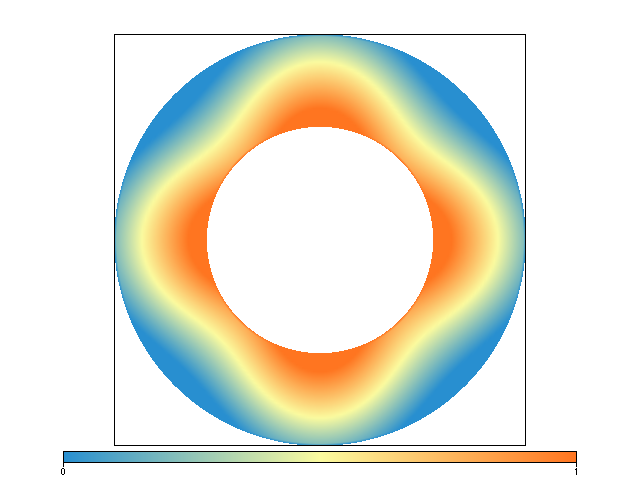

In [11]:
scene.show()

In [12]:
tBC = uw.conditions.DirichletCondition( variable=tField, indexSetsPerDof=(inner+outer))
advDiffSLE = uw.systems.AdvectionDiffusion(tField, tDotField, vField, fn_diffusivity=1.0, conditions=tBC)

In [13]:
viscosityFn = 1.0
bodyForceFn = tField * Ra * annulus.fn_unitvec_radial()
vBC = uw.conditions.RotatedDirichletCondition( 
                                    variable        = vField,
                                    indexSetsPerDof = (inner+outer, None),
                                    basis_vectors   = (annulus.bnd_vec_normal, annulus.bnd_vec_tangent))

In [14]:
stokesSLE = uw.systems.Stokes(vField, pField, 
                              fn_viscosity=1.0, 
                              fn_bodyforce=bodyForceFn, 
                              conditions=vBC, 
                              _removeBCs=False)

In [15]:
def postSolve():
    # realign solution using the rotation matrix on stokes
    uw.libUnderworld.Underworld.AXequalsX( stokesSLE._rot._cself,
                                           stokesSLE._velocitySol._cself, False)
    # remove null space - the solid body rotation velocity contribution
    uw.libUnderworld.StgFEM.SolutionVector_RemoveVectorSpace(stokesSLE._velocitySol._cself, 
                                                             stokesSLE._vnsVec._cself)


In [16]:
stokesSolver = uw.systems.Solver(stokesSLE)

In [17]:
# %%time

# initialise running storage
ts_t_vol_avg = []
ts_Nu_t = []
ts_Nu_b = []

# fields to checkpoint
fDict = {'velocity'   : vField,
         'temperature': tField,
         'tDot'       : tDotField}

animation.step

# controls for timesteping
tOld = tField.copy()
er=1.
its=0

# for i in range(nS):
while er > ss_tol and its < maxtimesteps:
    tOld.data[:] = tField.data[:] # record old values
    
    vField.data[boundaryNodes.data] = [0.,0.]
    stokesSolver.solve(callback_post_solve=postSolve)

    dt = advDiffSLE.get_max_dt()
    
    # visualisation goes here
#     scene.save()
#     scene.step += 1
    if its%1==0:
        checkpoint(annulus, fDict, None, None, its, prefix=outputPath)
    its+=1
        
    advDiffSLE.integrate(dt)

    absErr = uw.utils._nps_2norm(tOld.data-tField.data)
    magT   = uw.utils._nps_2norm(tOld.data)
    er = absErr/magT              # calculate relative variation

    t_vol_arg = annulus.integrate(tField)[0] / annulus.integrate(1.)[0]
    Nu_t =   np.log(f)/(2.*np.pi*(1.-f)) * dT_dr_outer_integral.evaluate()[0]
    Nu_b = f*np.log(f)/(2.*np.pi*(1.-f)) * dT_dr_inner_integral.evaluate()[0]
    
    ts_t_vol_avg.append(t_vol_arg)
    ts_Nu_t.append(Nu_t)
    ts_Nu_b.append(Nu_b)

Creating directory:  new_cynbench_2.1_test/


In [18]:
if uw.rank() == 0:
    stack = np.stack([np.array(ts_t_vol_avg), np.array(ts_Nu_t), np.array(ts_Nu_b)], axis=-1)
    with open(outputPath+'/data.dat', 'w') as oFile:
        np.savetxt(oFile , X=stack,
                   header="<T>, Nu_t, Nu_b",
                   fmt=['%.3e','%.3e','%.3e']) 
        